In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from helpers import imshow

In [6]:
def orbTrack(trainImg,trainKP,trainDesc,QueryImgBGR,h,w):
    MIN_MATCH_COUNT=100

    detector=cv2.ORB_create()

    #FLANN_INDEX_KDITREE=0
    #flannParam=dict(algorithm=FLANN_INDEX_KDITREE,tree=5)
    #searchParam = dict(checks=50)
    #flann=cv2.FlannBasedMatcher(flannParam,searchParam)
    #flann=cv2.FlannBasedMatcher(flannParam,{})
    
    QueryImg=cv2.cvtColor(QueryImgBGR,cv2.COLOR_BGR2GRAY)
    queryKP,queryDesc=detector.detectAndCompute(QueryImg,None)
    #matches=flann.knnMatch(queryDesc,trainDesc,k=2)
    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Match descriptors.
    #matches = bf.knnMatch(queryDesc,trainDesc)
    matchesF = bf.match(queryDesc,trainDesc)
    matchesB = bf.match(trainDesc,queryDesc)
    # Sort them in the order of their distance.
    #matches = sorted(matches, key = lambda x:x.distance)

    goodMatch=[]
    queryBorder = None
    qp = None
    for i in range(len(matchesF)):
        forward = matchesF[i]
        backward = matchesB[forward.trainIdx]
        if backward.trainIdx == forward.queryIdx:
            goodMatch.append(forward)
        
    if(len(goodMatch) > MIN_MATCH_COUNT):
        tp=[]
        qp=[]
        for m in goodMatch:
            tp.append(trainKP[m.trainIdx].pt)
            qp.append(queryKP[m.queryIdx].pt)
        tp,qp=np.float32((tp,qp))
        H,status=cv2.findHomography(tp,qp,cv2.RANSAC,3.0)
        
        #h,w=trainImg.shape
        trainBorder=np.float32([[[0,0],[0,h-1],[w-1,h-1],[w-1,0]]])
        queryBorder=cv2.perspectiveTransform(trainBorder,H)
        cv2.polylines(QueryImgBGR,[np.int32(queryBorder)],True,(0,255,0),5)
        return (1,queryBorder,qp)
        #print(queryBorder)
    else:
        #print("Not Enough match found")
        return (-1,queryBorder,qp)



In [7]:
def findOrientation(qp):
    tl = qp[0][0] #top left
    bl = qp[0][1] #botton left
    br = qp[0][2] #botton right
    tr = qp[0][3] #top right
    center = [(t1[0]+br[0])/2,(t1[1]+br[1])/2]
    theta = None
    #center is the center of the detected object
    #theta is the angle of it
    return center,theta
    

In [8]:
cam = cv2.VideoCapture(0)
img1 = cv2.imread("demo.jpg")
h,w,d = img1.shape
detector = cv2.ORB_create()
kp1, des1 = detector.detectAndCompute(img1,None)
while True:
    ret, img2 = cam.read()
    checker,dst,qp = orbTrack(img1,kp1,des1,img2,h,w)
    mask = img2.copy()
    if checker != -1:
        #center = findOrientation(qp)
        mask = cv2.polylines(img2,[np.int32(dst)],True,(0,255,0),5)
        print("YES")
    else:
        print("NO")
    keypressed = cv2.waitKey(5)
    if keypressed == 27:
        break
    cv2.imshow('mask',mask)
    
cam.release()
cv2.destroyAllWindows()

IndexError: list index out of range

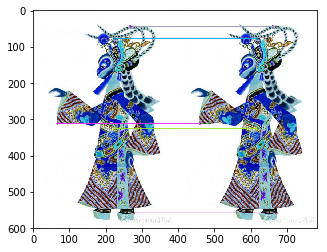

(<matplotlib.image.AxesImage at 0x128adbcf8>, None)